# GeoSSS Demo

This demo should quickly demonstrate the usage of the new sampling methods introduced in the package.
As a target we use a mixture of von Mises-Fisher (vMF) distribution on a 2-sphere. 

In [1]:
import geosss as gs
import numpy as np

## Setting Parameters

We need to set parameters for the samplers as well as the mixture of vMF distribution as target. Please note, concentration parameter $\kappa$ makes the mixture modes either concentrated around the mean (sharper) or more spread out for a lower $\kappa$.

Therefore, feel free to play with these parameters. However, please note, the demo visualization accepts only $d=3$, but in general, this can be used on any dimension. 

In [2]:
# parameters for mixture of von Mises-Fisher (vMF)
# distributions
d = 3  # required dimension
K = 3  # number of mixture components
kappa = 80.0  # concentration parameter

# mus (mean directions) of the vMF mixture components for a 2-sphere
# represented as a unit quaternion.
mus = np.array(
    [
        [0.86981638, -0.37077248, 0.32549536],
        [-0.19772391, -0.89279985, -0.40473902],
        [0.19047726, 0.22240888, -0.95616562],
    ]
)

# sampler parameters
n_samples = int(1e3)  # no. of samples
burnin = int(0.1 * n_samples)  # burnin samples
seed = 3521  # sampler seed

## Creating the vMF target

By calling the `VonMisesFisher` class and `MixtureModel` class for the library, we can construct our pdf target.

In [3]:
# target pdf
vmfs = [gs.VonMisesFisher(kappa * mu) for mu in mus]
pdf = gs.MixtureModel(vmfs)

## Sampling

We compare our samplers, GeoSSS (reject) and GeoSSS (shrink) with random walk Metropolis-Hastings (RWMH) and Hamiltonian Monte Carlo (HMC). The classes for these are as follows

- GeoSSS (reject): `RejectionSphericalSliceSampler`
- GeoSSS (shrink): `ShrinkageSphericalSliceSampler`
- RWMH: `MetropolisHastings`
- HMC: `SphericalHMC`

In [4]:
# initial state of the samplers
init_state = np.array([-0.86333052, 0.18685286, -0.46877117])

# sampling with the four samplers
samples = {}

# GeoSSS (reject): ideal geodesic slice sampler
rsss = gs.RejectionSphericalSliceSampler(pdf, init_state, seed)
samples["sss-reject"] = rsss.sample(n_samples, burnin)

# GeoSSS (shrink): shrinkage-based geodesic slice sampler
ssss = gs.ShrinkageSphericalSliceSampler(pdf, init_state, seed)
samples["sss-shrink"] = ssss.sample(n_samples, burnin)

# RWMH: random-walk Metropolis Hastings
rwmh = gs.MetropolisHastings(pdf, init_state, seed)
samples["rwmh"] = rwmh.sample(n_samples, burnin)

# HMC: Hamiltonian Monte Carlo
hmc = gs.SphericalHMC(pdf, init_state, seed)
samples["hmc"] = hmc.sample(n_samples, burnin)

## Visualization 3D

Visualization the samples as a scatter plot on a 2-sphere (reproduce the demo in README)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

from geosss.distributions import Distribution

METHODS = ("sss-reject", "sss-shrink", "rwmh", "hmc")
ALGOS = {
    "sss-reject": "geoSSS (reject)",
    "sss-shrink": "geoSSS (shrink)",
    "rwmh": "RWMH",
    "hmc": "HMC",
}


def sphere_pdf(n_grid: int, pdf: Distribution):
    """spherical grid with pdf"""

    # spherical grid
    u = np.linspace(0, np.pi, n_grid)
    v = np.linspace(0, 2 * np.pi, n_grid)

    u_grid, v_grid = np.meshgrid(u, v)
    vertices = np.stack(
        [
            np.cos(v_grid) * np.sin(u_grid),
            np.sin(v_grid) * np.sin(u_grid),
            np.cos(u_grid),
        ],
        axis=2,
    )

    # spherical to cartesian
    sph2cart = (
        np.outer(np.cos(v), np.sin(u)),
        np.outer(np.sin(v), np.sin(u)),
        np.outer(np.ones_like(u), np.cos(u)),
    )

    # pdf values for the grid
    pdf_vals = np.array([np.exp(pdf.log_prob(val)) for val in vertices])

    return sph2cart, pdf_vals


def compare_samplers_3d(
    pdf: Distribution,
    samples: dict,
    n_grid: int = 100,
):
    for method in METHODS:
        msg = "visualization accepts only 3 dimension"
        assert samples[method].shape[1] == 3, msg

    sph2cart, pdf_vals = sphere_pdf(n_grid, pdf)
    pdfnorm = Normalize(vmin=pdf_vals.min(), vmax=pdf_vals.max())

    fig, axes = plt.subplots(
        2, 2, figsize=(8, 8), subplot_kw={"projection": "3d"}, sharex=True, sharey=True
    )

    for ax, method in zip(axes.flat, METHODS):
        ax.computed_zorder = False
        ax.plot_surface(
            *sph2cart, facecolors=plt.cm.terrain_r(pdfnorm(pdf_vals)), alpha=1, zorder=1
        )

        x = samples[method]
        ax.scatter(*x.T, c="tab:red", s=1, alpha=0.4, zorder=2)
        ax.set_title(ALGOS[method], pad=-30)
        ax.set_aspect("equal")
        ax.view_init(-140, 150)
        ax.axis("off")

    fig.tight_layout()
    plt.show()

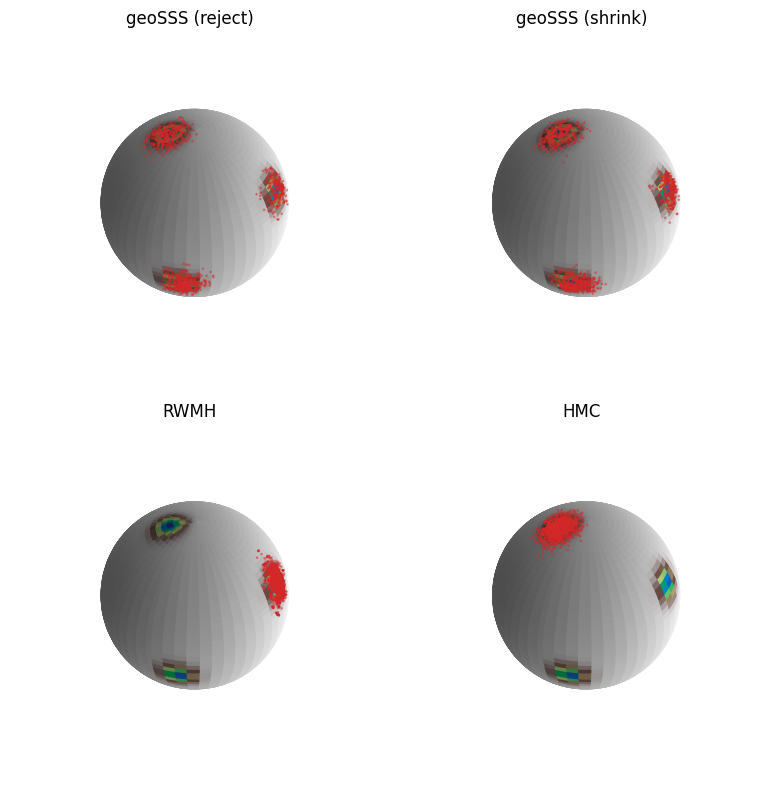

In [ ]:
compare_samplers_3d(pdf, samples)